In [98]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from pathlib import Path

In [99]:
# 切换路径
#path = Path("/Users/wangshuaibo/Documents/北京悦动/脑卒中项目/阿帅笔记/测试数据及分析结果/20230418鞋垫医院预实验/Openmat")
path = Path(input("请输入当前路径："))


In [100]:
os.chdir(path)
print(f"当前路径为:{os.getcwd()}")

当前路径为:/Users/wangshuaibo/Documents/北京悦动/脑卒中项目/阿帅笔记/测试数据及分析结果/20230418鞋垫医院预实验/XsensMVN


In [101]:
# 打开文件
file = "郑金增-001.xlsx"
excelfile = pd.ExcelFile(file,engine="openpyxl")
excelfile.sheet_names

['General Information',
 'Markers',
 'Segment Orientation - Quat',
 'Segment Orientation - Euler',
 'Segment Position',
 'Segment Velocity',
 'Segment Acceleration',
 'Segment Angular Velocity',
 'Segment Angular Acceleration',
 'Joint Angles ZXY',
 'Joint Angles XZY',
 'Ergonomic Joint Angles ZXY',
 'Ergonomic Joint Angles XZY',
 'Center of Mass',
 'Sensor Free Acceleration',
 'Sensor Magnetic Field',
 'Sensor Orientation - Quat',
 'Sensor Orientation - Euler']

In [102]:
df = pd.read_excel(file, engine="openpyxl",sheet_name="Joint Angles ZXY")

In [103]:
# 左足跟着地到再次着地对应的索引
Right_start = 845
Right_end = 957

# 右足跟着地到再次着地对应的索引
Left_start = 900
Left_end = 1008

Left_joints = ['Left Hip Abduction/Adduction',
       'Left Hip Internal/External Rotation', 'Left Hip Flexion/Extension',
       'Left Knee Abduction/Adduction', 'Left Knee Internal/External Rotation',
       'Left Knee Flexion/Extension', 'Left Ankle Abduction/Adduction',
       'Left Ankle Internal/External Rotation',
       'Left Ankle Dorsiflexion/Plantarflexion',
       'Left Ball Foot Abduction/Adduction',
       'Left Ball Foot Internal/External Rotation',
       'Left Ball Foot Flexion/Extension']

Right_joints = ['Right Hip Abduction/Adduction', 'Right Hip Internal/External Rotation',
       'Right Hip Flexion/Extension', 'Right Knee Abduction/Adduction',
       'Right Knee Internal/External Rotation', 'Right Knee Flexion/Extension',
       'Right Ankle Abduction/Adduction',
       'Right Ankle Internal/External Rotation',
       'Right Ankle Dorsiflexion/Plantarflexion',
       'Right Ball Foot Abduction/Adduction',
       'Right Ball Foot Internal/External Rotation',
       'Right Ball Foot Flexion/Extension']

Left_df = df[Left_joints].iloc[Left_start:Left_end]
Right_df = df[Right_joints].iloc[Right_start:Right_end]

In [104]:
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d

def DataFrameInterp1d(df,joints):
    # 将数据框转换为 NumPy 数组
    arr = df.to_numpy()

    # 设置新数组长度为 101
    new_length = 101

    # 生成新的 X 坐标轴
    x_old = np.arange(len(arr))
    x_new = np.linspace(0, len(arr) - 1, new_length)

    # 对每一列数据进行线性插值
    new_arrs = []
    for i in range(arr.shape[1]):
        f = interp1d(x_old, arr[:, i], kind='linear')
        new_arr = f(x_new)
        new_arrs.append(new_arr)

    # 将新数组转换为数据框
    norm_df = pd.DataFrame(np.column_stack(new_arrs), columns=joints)
    return norm_df

In [105]:
# 左右步态标准化
Right_norm_df = DataFrameInterp1d(Right_df,Right_joints)
Left_norm_df = DataFrameInterp1d(Left_df,Left_joints)

## 下肢关节角度图片绘制函数

In [106]:
# 绘制下肢关节角度
def JointanglesPlot(Left_norm_df,Right_norm_df,joint,Affected_side):

    # 确定不同关节对应的术语
    if joint in ["Hip","Knee"]:
        actions = ["Flexion/Extension","Abduction/Adduction","Internal/External Rotation"]
    else:
        actions = ["Dorsiflexion/Plantarflexion","Abduction/Adduction","Internal/External Rotation"]

    # 将左右、关节以及不同平面的运动拼接成专业的术语
    sides = ["Left","Right"]
    sides_joint_actions = [side + " "+ joint + " "+ action for side in sides for action in actions]

    # 绘制画布
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,3),dpi=500)

    # 制定左右腿那个是患侧，使用不同的绘制方式
    Affected_side_plot = ["pink","--","患侧"]
    Healthy_side_plot = ["green","-","健侧"]
    if Affected_side == "Left":
        left_color, left_linestyle, Left_label = Affected_side_plot
        right_color, right_linestyle, right_label = Healthy_side_plot 
    elif Affected_side == "Right":
        right_color, right_linestyle, right_label = Affected_side_plot 
        left_color, left_linestyle, Left_label = Healthy_side_plot 
    else:
        raise ValueError("请制定患侧腿：Left或者Right")


    # 循环绘制关节每个平面左右腿的数据
    for i, sides_joint_action in enumerate(sides_joint_actions):
        if i <= 2:
            Left_norm_df[sides_joint_action].plot(ax=axs[i],
                                                  color=left_color,linestyle = left_linestyle,label=Left_label)
        else:
            Right_norm_df[sides_joint_action].plot(ax=axs[i%3],
                                                   color=right_color,linestyle=right_linestyle,label=right_label)

    # 保证可以显示中文, 字体使用黑体
    plt.rcParams['font.sans-serif'] = ['Heiti TC']
    plt.rcParams['font.family'] = ['Heiti TC']
    plt.rcParams['axes.unicode_minus'] = False

    # 设置每个图片的格式
    for ax in axs:
        ax.spines['top'].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_visible(False)
        ax.spines['bottom'].set_linewidth(1)
        ax.set_xlim(0,100)
        ax.tick_params(axis='y', length=0, width=0)
        ax.grid(axis='y', linestyle='--', linewidth=0.5)
        ax.legend()

    axs[1].set_xlabel("步态周期：同侧脚从足跟首次触地到下次触地")
    axs[0].set_ylabel("角度(°)")

    # 不同的关节角度使用的术语不同
    if joint in ["Hip","Knee"]:
        angles_cn = ["屈曲(+)/伸展(-)角度","内收(+)/外展(-)角度","内旋(+)/外旋(-)角度"]
    else:
        angles_cn = ["背屈(+)/跖屈(-)角度", "内翻(+)/外翻(-)角度","内旋(+)/外旋(-)角度"]   
    for i,angle_cn in enumerate(angles_cn):
        axs[i].set_title(angle_cn)

    # joint 对应的中文
    joint_cn = {"Hip":["髋"],"Knee":["膝"],"Ankle":["踝"]}
    plt.suptitle(f"{joint_cn[joint][0]}关节角度",y=1.1,fontsize=16)


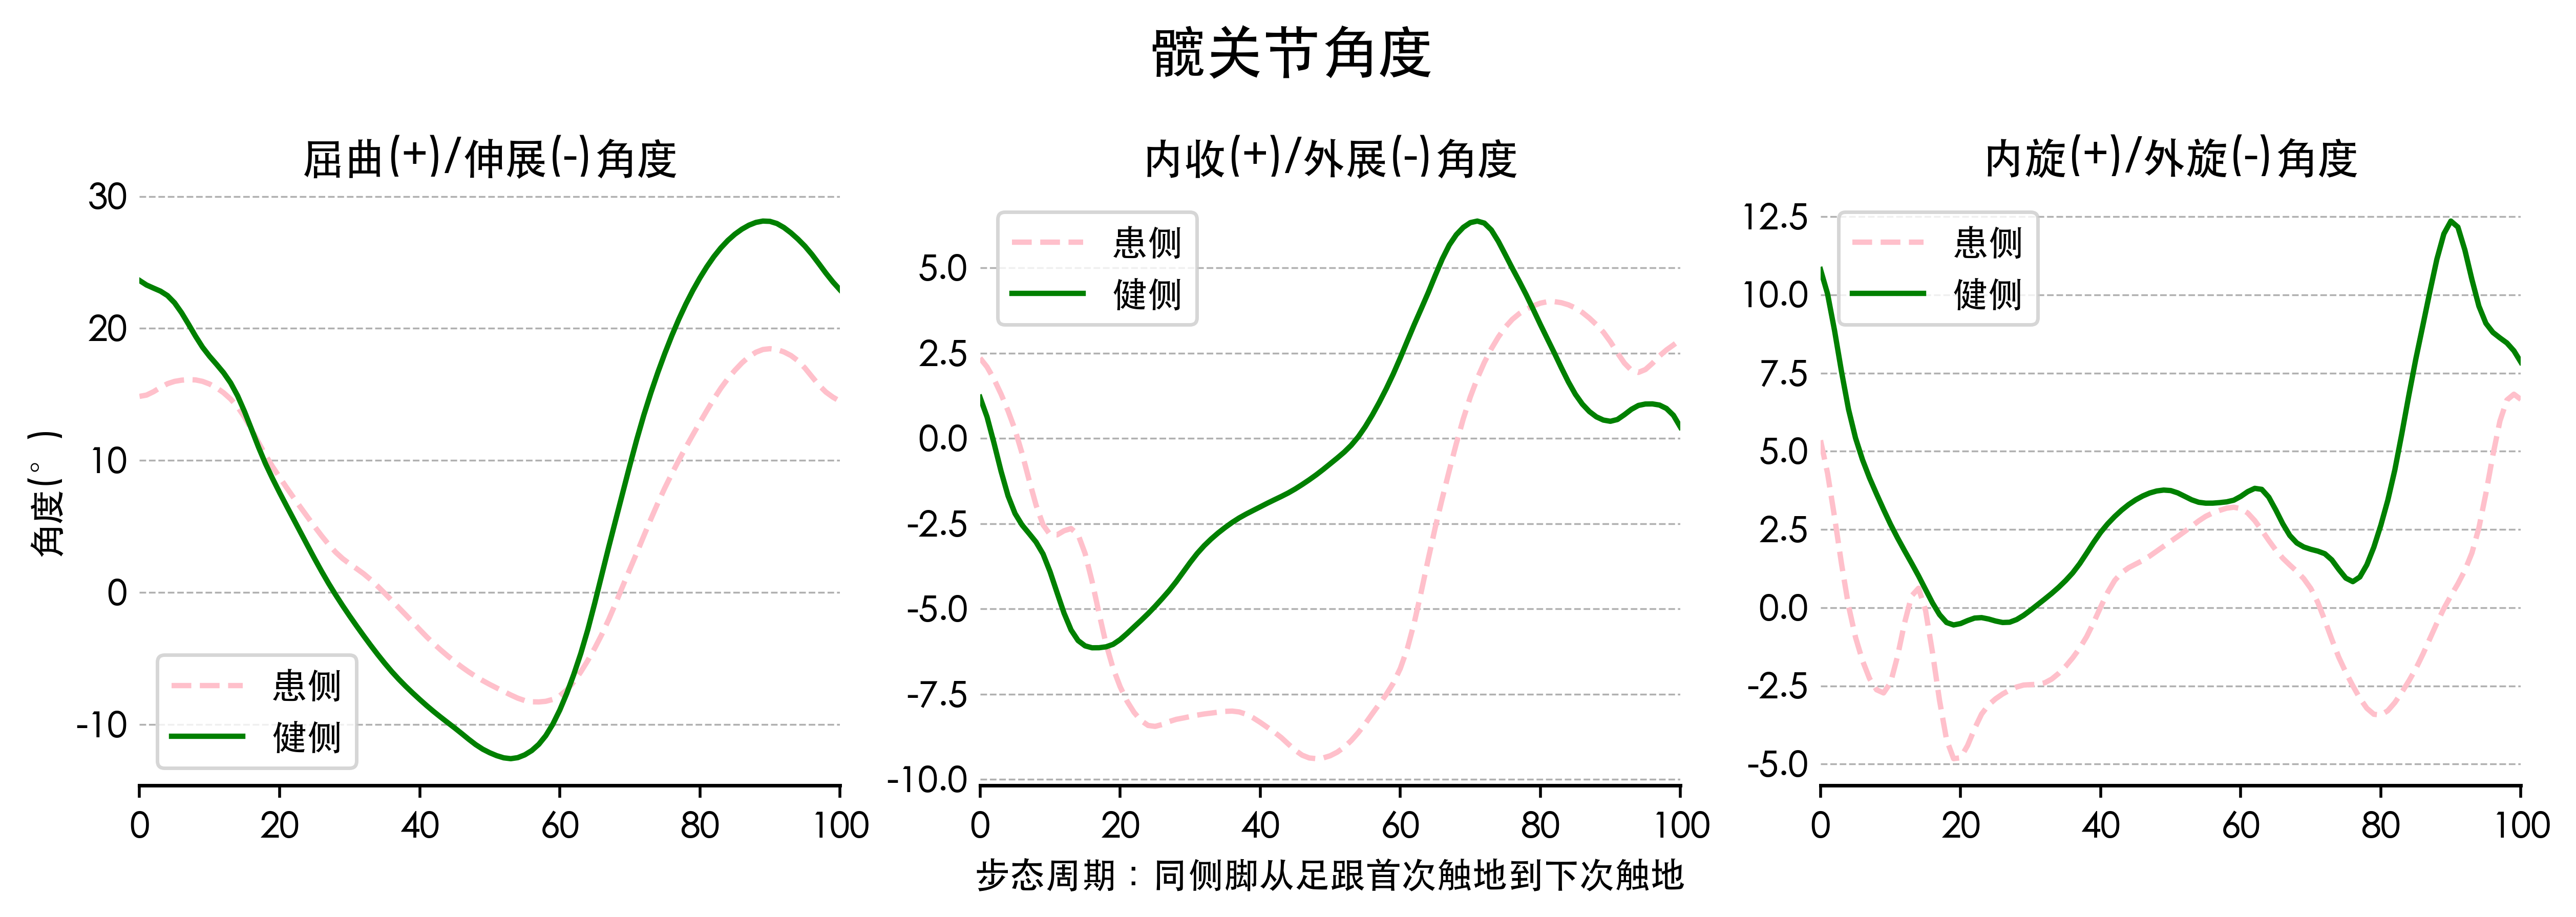

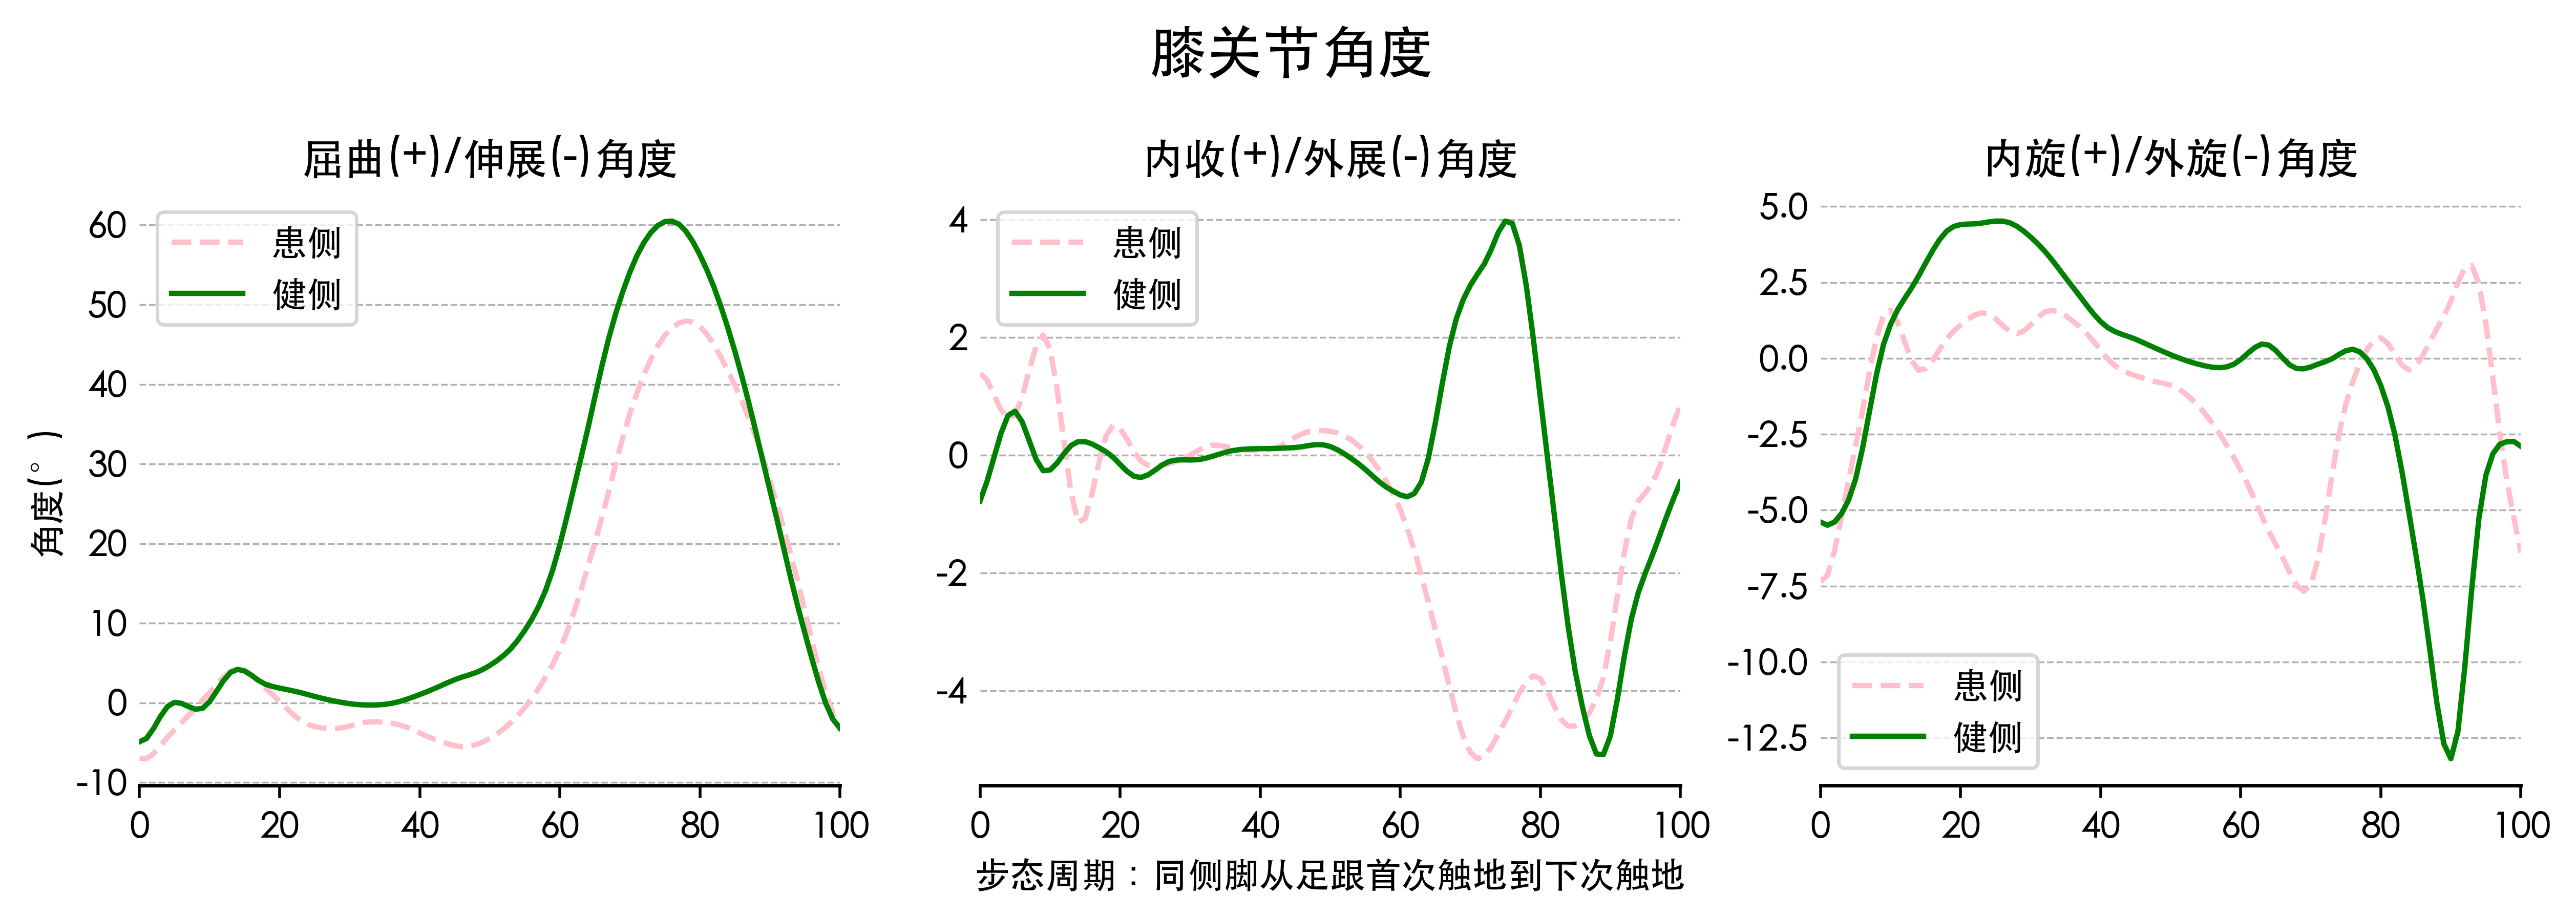

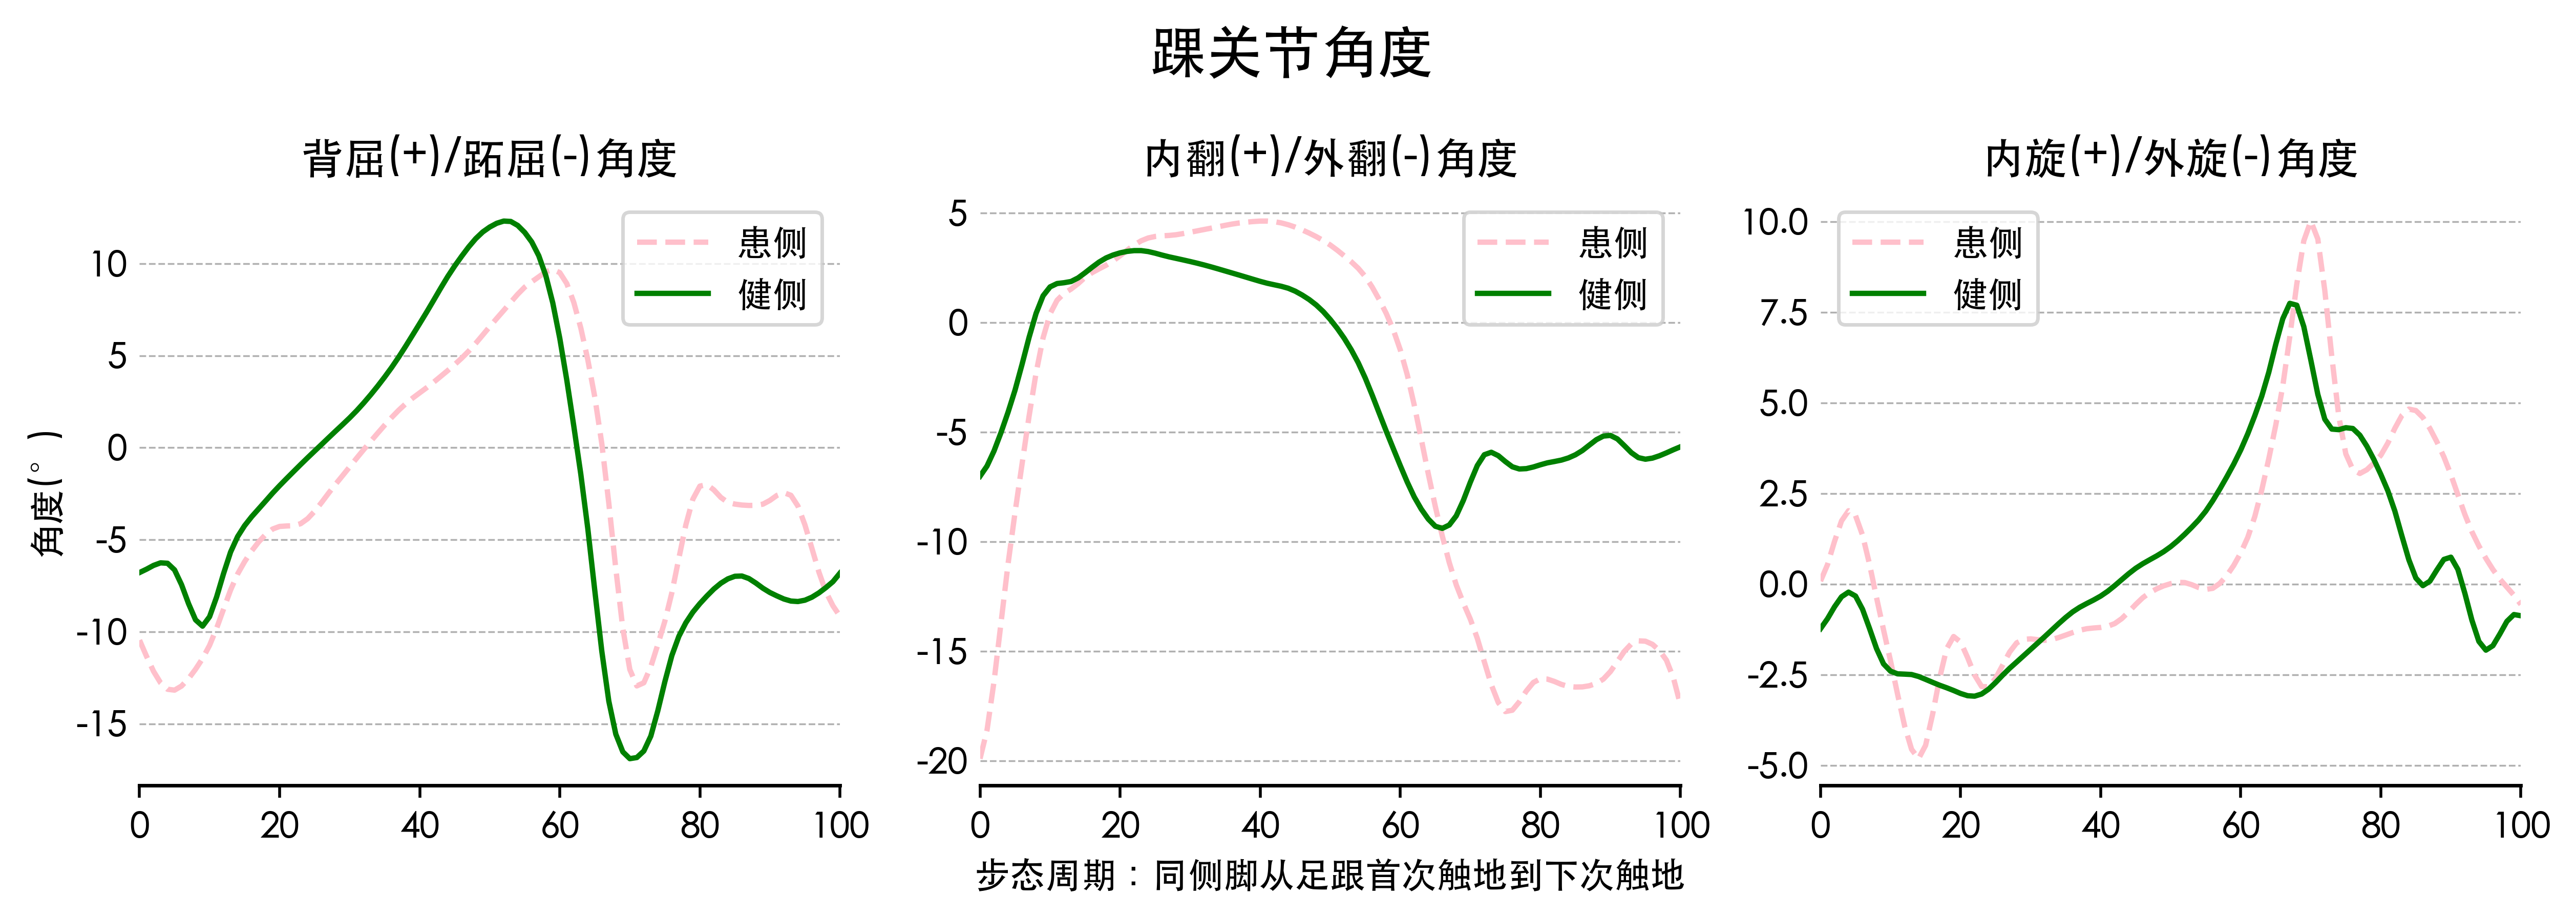

In [107]:
# 制定患侧
Affected_side = "Left"
# 循环绘制髋、膝、踝的角度
for joint in ["Hip","Knee","Ankle"]:
    JointanglesPlot(Left_norm_df,Right_norm_df,joint,Affected_side)

## Todo
自动保存绘制的图片